In [50]:
# pip: torch, numpy, pandas
import math, random, pandas as pd, torch as th
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ---- Data ----
class ReDataset(Dataset):
    """
    CSV must have columns: dataset_source, family, re_tau, re_theta, Re
    Context vector = [log10(Re_like), onehot(family), onehot(re_kind)]
    dataset_source is ignored
    """
    REKINDS = ("re_tau", "re_theta", "Re")

    def __init__(self, csv_path, add_geometry=False, n_nodes=64,
                 use_family_in_ctx=True, use_rekind_in_ctx=True):
        df = pd.read_csv(csv_path)

        # Build ID maps
        self.family_to_id = {v: i for i, v in enumerate(sorted(df["family"].astype(str).unique()))}
        self.num_families = len(self.family_to_id)
        self.num_rekinds  = len(self.REKINDS)

        rows = []
        for r in df.itertuples(index=False):
            fam_name = str(r.family)
            fam_id = self.family_to_id[fam_name]

            # choose Reynolds-like value + which kind
            re_val, rk_id = None, None
            for rk_id, key in enumerate(self.REKINDS):
                v = getattr(r, key, float("nan"))
                try: v = float(v)
                except Exception: v = float("nan")
                if v == v and v > 0.0:
                    re_val = v
                    break
            if re_val is None:
                continue

            rows.append((fam_id, re_val, rk_id))

        if len(rows) < 2:
            raise ValueError("Not enough valid rows after filtering Reynolds-like values.")

        self.rows = rows
        self.add_geometry = add_geometry
        self.use_family_in_ctx = use_family_in_ctx
        self.use_rekind_in_ctx = use_rekind_in_ctx
        self.geom = th.linspace(0.0, 1.0, n_nodes).unsqueeze(1) if add_geometry else None

    def __len__(self): return len(self.rows)

    def __getitem__(self, i):
        fam_id, re_val, rk_id = self.rows[i]
        feats = [math.log10(float(re_val))]

        if self.use_family_in_ctx:
            fam_oh = th.nn.functional.one_hot(th.tensor(fam_id), num_classes=self.num_families).float()
            feats.extend(fam_oh.tolist())

        if self.use_rekind_in_ctx:
            rk_oh = th.nn.functional.one_hot(th.tensor(rk_id), num_classes=self.num_rekinds).float()
            feats.extend(rk_oh.tolist())

        item = {
            "ctx": th.tensor(feats, dtype=th.float32),
            "fam": th.tensor(fam_id, dtype=th.long),
            "log10_re": th.tensor(math.log10(float(re_val)), dtype=th.float32),
            "rk": th.tensor(rk_id, dtype=th.long),
            "src": float("nan"),   # placeholder for dataset_source
        }
        if self.add_geometry:
            item["geom"] = self.geom.clone()
        return item


# ---- Model ----
class FlowEncoder(nn.Module):
    def __init__(self, in_dim, out_dim=32):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(in_dim, 64), nn.ReLU(),
                                 nn.Linear(64, out_dim))
    def forward(self, x): return self.net(x)

class GeometryEncoder(nn.Module):
    def __init__(self, in_dim=1, width=32, out_dim=32):
        super().__init__()
        self.node_mlp = nn.Sequential(nn.Linear(in_dim, width), nn.ReLU(),
                                      nn.Linear(width, out_dim), nn.ReLU())
    def forward(self, nodes):           # nodes: (N,1)
        h = self.node_mlp(nodes)        # (N,out_dim)
        return h.mean(dim=0)            # simple global avg pool

class Projector(nn.Module):
    def __init__(self, in_dim, proj_dim=128):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(in_dim, 256), nn.ReLU(),
                                 nn.Linear(256, proj_dim))
    def forward(self, z):
        p = self.net(z)
        return th.nn.functional.normalize(p, dim=-1)

# ---- InfoNCE ----
def info_nce(anchor, positive, negatives, temperature=0.07):
    # anchor/positive: (D,), negatives: (K,D)
    a = anchor.unsqueeze(0)             # (1,D)
    logits_pos = (a @ positive.unsqueeze(1)).squeeze() / temperature
    logits_neg = (a @ negatives.T).squeeze() / temperature
    logits = th.cat([logits_pos.unsqueeze(0), logits_neg], dim=0)
    labels = th.zeros(1, dtype=th.long) # index 0 is the positive
    return nn.CrossEntropyLoss()(logits.unsqueeze(0), labels)

# ---- Training loop ----
def train(csv_path,
          add_geometry=False,
          steps=100,
          batch_size=64,
          lr=1e-3,
          seed=0,
          use_family_in_ctx=True,
          use_rekind_in_ctx=True):
    import math, random, pandas as pd, torch as th
    th.manual_seed(seed); random.seed(seed)

    ds = ReDataset(csv_path,
                   add_geometry=add_geometry,
                   use_family_in_ctx=use_family_in_ctx,
                   use_rekind_in_ctx=use_rekind_in_ctx)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=False)

    first_batch = next(iter(dl))
    ctx_example = first_batch["ctx"]                 # (B, D)
    assert ctx_example.dim() == 2, "ctx should be (batch, features)"
    ctx_in = ctx_example.shape[1]

    fenc = FlowEncoder(ctx_in, 32)
    genc = GeometryEncoder() if add_geometry else None
    proj = Projector(32 if not add_geometry else (32+32), 128)

    params = list(fenc.parameters()) + list(proj.parameters())
    if genc: params += list(genc.parameters())
    opt = th.optim.AdamW(params, lr=lr, weight_decay=1e-4)

    last_L = float("nan")

    for step in range(steps):
        for batch in dl:
            ctx = batch["ctx"]                          # (B, ctx_in)
            fam = batch["fam"]                          # (B,)
            geom = batch.get("geom", None)

            # sanity: same ctx length every time
            if ctx.shape[1] != ctx_in:
                raise RuntimeError(f"Inconsistent ctx length: got {ctx.shape[1]}, expected {ctx_in}")

            B = ctx.shape[0]
            if B < 2:
                continue

            # Encode all embeddings
            z_list = []
            for i in range(B):
                c = fenc(ctx[i])
                if add_geometry:
                    g = genc(geom[i] if isinstance(geom, th.Tensor) and geom.ndim == 3 else geom)
                    z = th.cat([g, c], dim=-1)
                else:
                    z = c
                z_list.append(proj(z))
            Z = th.stack(z_list, dim=0)                 # (B, 128)

            # Build InfoNCE losses (same-family positives, different-family negatives)
            losses = []
            for i in range(B):
                same = (fam == fam[i]).nonzero(as_tuple=True)[0]
                diff = (fam != fam[i]).nonzero(as_tuple=True)[0]
                if same.numel() <= 1 or diff.numel() == 0:
                    continue
                same_others = same[same != i]
                if same_others.numel() == 0:
                    continue
                j = same_others[th.randint(0, same_others.numel(), ()).item()]
                K = min(16, diff.numel())
                neg_idx = diff[th.randperm(diff.numel())[:K]]
                loss = info_nce(Z[i], Z[j], Z[neg_idx])
                losses.append(loss)

            if not losses:
                continue

            L = th.stack(losses).mean()
            opt.zero_grad(); L.backward(); opt.step()
            last_L = L.item()

        # progress print
        if (step+1) % max(1, steps//10) == 0:
            if math.isfinite(last_L):
                print(f"step {step+1}/{steps}  L={last_L:.4f}")
            else:
                print(f"step {step+1}/{steps}  L=— (no valid pairs this step)")

    return fenc, genc, proj



fenc, genc, proj = train('flows_augmented.csv', add_geometry=False, steps=5, use_family_in_ctx=True)

step 1/5  L=1.9543
step 2/5  L=1.0379
step 3/5  L=0.2032
step 4/5  L=0.0113
step 5/5  L=0.0013


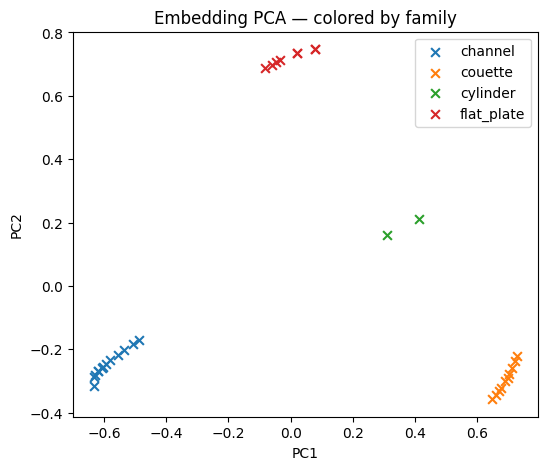

In [51]:
import math, numpy as np, pandas as pd, torch as th
import matplotlib.pyplot as plt

CSV_PATH = "flows_augmented.csv"
USE_FAMILY_IN_CTX = True

def _pick_re_like(row):
    for k in ("re_tau", "re_theta", "Re"):
        v = row.get(k, np.nan)
        try: v = float(v)
        except Exception: v = np.nan
        if np.isfinite(v) and v > 0: return v
    return np.nan

# identify which Reynolds-kind each row used
def _pick_re_kind(row):
    for k in ("re_tau", "re_theta", "Re"):
        v = row.get(k, np.nan)
        try: v = float(v)
        except Exception: v = np.nan
        if np.isfinite(v) and v > 0:
            return k
    return "none"


def _pca_2d(X):
    Xc = X - X.mean(axis=0, keepdims=True)
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    return Xc @ Vt[:2].T

# Load and prep rows
df = pd.read_csv(CSV_PATH)
df["Re_like"] = df.apply(_pick_re_like, axis=1)
df = df[np.isfinite(df["Re_like"]) & (df["Re_like"] > 0)].copy()
df["log10_re"] = np.log10(df["Re_like"]).astype(np.float32)
df["family"] = df["family"].astype(str)
df["dataset_source"] = df["dataset_source"].astype(str)
df["re_kind"] = df.apply(_pick_re_kind, axis=1)

# Build context vectors to match the trained encoder input dim
in_dim_expected = fenc.net[0].in_features
if USE_FAMILY_IN_CTX:
    num_fams_expected = in_dim_expected - 1

    uniq_fams = sorted(df["family"].unique().tolist())
    kept_fams = uniq_fams[:num_fams_expected]
    fam_to_idx = {fam:i for i, fam in enumerate(kept_fams)}

    ctx_list = []
    fam_idx_list = []
    for _, r in df.iterrows():
        x = [r["log10_re"]]
        onehot = np.zeros(num_fams_expected, dtype=np.float32)
        if r["family"] in fam_to_idx:
            onehot[fam_to_idx[r["family"]]] = 1.0
            fam_idx_list.append(fam_to_idx[r["family"]])
        else:
            fam_idx_list.append(-1)
        x.extend(onehot.tolist())
        ctx_list.append(x)
else:
    num_fams_expected = 0
    fam_to_idx = {}
    fam_idx_list = [0]*len(df)
    ctx_list = [[v] for v in df["log10_re"].to_numpy(dtype=np.float32)]

ctx = th.tensor(np.array(ctx_list, dtype=np.float32))

# Encode -> project
with th.no_grad():
    Z = proj(fenc(ctx)).cpu().numpy()   # (N, D)

# PCA -> 2D
X2 = _pca_2d(Z)

# Plot by family
plt.figure(figsize=(6,5))
families_for_plot = sorted(df["family"].unique().tolist())
for fam in families_for_plot:
    idx = np.where(df["family"].values == fam)[0]
    plt.scatter(X2[idx,0], X2[idx,1], s=40, marker="x", label=fam)

plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("Embedding PCA — colored by family"); plt.legend()

plt.show()
